In [1]:
import numpy as np
import pandas as pd 

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from keras.models import Sequential
import matplotlib.pyplot as plt
import seaborn as sns

#for RBN
from keras.layers import Layer, Flatten, Dense
from keras import backend as K
from sklearn.metrics import classification_report


from sklearn.model_selection import StratifiedKFold
from keras import regularizers
from tensorflow.keras.utils import to_categorical


In [2]:
#fixed random seed for reproducibility 
np.random.seed(0)

In [3]:
# load dataset (input variables = X, output variables = Y)
df = pd.read_csv("TrainingData.csv")

#count the number of occurances for each osID
OsID_counts = df['OsID'].value_counts()

#filter for osIDs that have 10 or more occurances
OsID_counts_filtered = OsID_counts[OsID_counts >= 10]

#assign a label for each osID 
OsID_labels = {}
class_no = 1
for osID in OsID_counts_filtered.index:
    OsID_labels[osID] = class_no
    class_no +=1

#filter the dataset with osID that contain 10 or more occurances
dataGene = df[df['OsID'].isin(OsID_counts_filtered.index)]

dataGene = dataGene.drop(['Class', 'Trait'],axis=1)

# Add a new column 'class' to the filtered dataset
dataGene['class'] = dataGene['OsID'].map(OsID_labels)

#print("Summary of dataGene:\n",dataGene.describe())


In [4]:
X = dataGene.drop(['class','OsID'], axis=1) # exclude class & OsID column
Y = dataGene['class']

#input feature names in order of descending importance scores in MI feature selection method
feature_names = ['CoExpression', 'PCC', 'PPI', 'Root10DaysSeedling', 'Leaf21DaysSeedling', 
                 'Leaf45DaysOldPlant', 'log_2FoldChange', 'ET', 'Shoot10DaysSeedling', 'Shoot3DaysSeedling', 
                 'Shoot35DaysSeedling', 'Shoot14DaysSeedling', 'Root17DaysSeedling', 'Shoot17DaysSeedling', 'Shoot21DaysSeedling', 
                 'Root24DaysSeedling', 'Root14DaysSeedling', 'Root21DaysSeedling', 'Root52DaysSeedling', 'Root35DaysSeedling']

X_fs = X.reindex(columns=feature_names)

print("Shape of X:\n",X_fs.shape)
print("Shape of Y:\n",Y.shape)

# Statistical summary of the variables
#print("Summary of X:\n",X_fs.describe())
#print("Summary of Y:\n",Y.describe())

# Check for class imbalance
print(df.groupby(Y).size())

# change both input and target variables datatype to ndarray
X_fs = X_fs.values # 2-D array

# select target variable 

Y = Y.values #1-D array
Y = Y.reshape(-1, 1)

Shape of X:
 (41110, 20)
Shape of Y:
 (41110,)
class
1.0      1800
2.0      1296
3.0      1260
4.0      1218
5.0      1026
6.0      1008
7.0       930
8.0       912
9.0       880
10.0      798
11.0      792
12.0      759
13.0      729
14.0      720
15.0      702
16.0      693
17.0      672
18.0      640
19.0      625
20.0      570
21.0      546
22.0      506
23.0      483
24.0      448
25.0      432
26.0      384
27.0      360
28.0      360
29.0      320
30.0      312
         ... 
344.0      12
345.0      12
346.0      12
347.0      12
348.0      12
349.0      12
350.0      12
351.0      12
352.0      12
353.0      12
354.0      12
355.0      12
356.0      11
357.0      11
358.0      11
359.0      11
360.0      11
361.0      11
362.0      10
363.0      10
364.0      10
365.0      10
366.0      10
367.0      10
368.0      10
369.0      10
370.0      10
371.0      10
372.0      10
373.0      10
Length: 373, dtype: int64


Class=0, n=1800 (4.378%)
Class=1, n=1296 (3.153%)
Class=2, n=1260 (3.065%)
Class=3, n=1218 (2.963%)
Class=4, n=1026 (2.496%)
Class=5, n=1008 (2.452%)
Class=6, n=930 (2.262%)
Class=7, n=912 (2.218%)
Class=8, n=880 (2.141%)
Class=9, n=798 (1.941%)
Class=10, n=792 (1.927%)
Class=11, n=759 (1.846%)
Class=12, n=729 (1.773%)
Class=13, n=720 (1.751%)
Class=14, n=702 (1.708%)
Class=15, n=693 (1.686%)
Class=16, n=672 (1.635%)
Class=17, n=640 (1.557%)
Class=18, n=625 (1.520%)
Class=19, n=570 (1.387%)
Class=20, n=546 (1.328%)
Class=21, n=506 (1.231%)
Class=22, n=483 (1.175%)
Class=23, n=448 (1.090%)
Class=24, n=432 (1.051%)
Class=25, n=384 (0.934%)
Class=26, n=360 (0.876%)
Class=27, n=360 (0.876%)
Class=28, n=320 (0.778%)
Class=29, n=312 (0.759%)
Class=30, n=312 (0.759%)
Class=31, n=306 (0.744%)
Class=32, n=304 (0.739%)
Class=33, n=299 (0.727%)
Class=34, n=297 (0.722%)
Class=35, n=296 (0.720%)
Class=36, n=280 (0.681%)
Class=37, n=264 (0.642%)
Class=38, n=260 (0.632%)
Class=39, n=253 (0.615%)
Clas

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


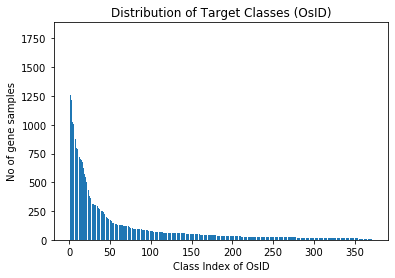

In [5]:
y_labelenc = LabelEncoder().fit_transform(Y)

from collections import Counter
# summarize distribution
counter = Counter(y_labelenc)

# sort counter by keys
counter = dict(sorted(counter.items()))


for k,v in counter.items():
 per = v / len(y_labelenc) * 100
 print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
# plot the distribution
plt.bar( counter.keys(), counter.values())

plt.ylabel('No of gene samples')
plt.xlabel('Class Index of OsID')
plt.title('Distribution of Target Classes (OsID)')
plt.show()

In [6]:
# prepare target data
def prepare_targets(y_train, y_test):
	le = LabelEncoder()
	
	#fit the encoders only to the training data and then transform both train and test data
	y_train_enc = le.fit_transform(y_train)
	y_test_enc = le.transform(y_test)

	return y_train_enc, y_test_enc

In [7]:
# define the RBFLayer layer as a custom layer
class RBFLayer(Layer):
    def __init__(self, units, gamma, **kwargs):
        super(RBFLayer, self).__init__(**kwargs)
        self.units = units
        self.gamma = K.cast_to_floatx(gamma)

    def build(self, input_shape):
        self.mu = self.add_weight(name='mu',
                                  shape=(int(input_shape[1]), self.units),
                                  initializer='uniform',
                                  trainable=True)
        super(RBFLayer, self).build(input_shape)

    def call(self, inputs):
        diff = K.expand_dims(inputs) - self.mu
        l2 = K.sum(K.pow(diff, 2), axis=1)
        res = K.exp(-1 * self.gamma * l2)
        return res

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.units)

In [8]:
# prepare target data
def prepare_targets(y_train, y_test):
	le = LabelEncoder()
	
	#fit the encoders only to the training data and then transform both train and test data
	y_train_enc = le.fit_transform(y_train)
	y_test_enc = le.transform(y_test)

	return y_train_enc, y_test_enc

In [9]:
# define baseline model (RBFN)
def RBFN_model(input_dim):

    model = Sequential()
    model.add(Flatten(input_shape=(input_dim,)))
    #add the RBF layer
    model.add(RBFLayer(10, 0.5))
    
    model.add(Dense(60, input_dim=input_dim, activation='relu',bias_initializer='normal',kernel_regularizer=regularizers.l2(0.0001)))
    model.add(Dense(20,bias_initializer='normal',activation='relu',kernel_regularizer=regularizers.l2(0.0001)))
    model.add(Dense(20,bias_initializer='normal',activation='relu',kernel_regularizer=regularizers.l2(0.0001)))
    model.add(Dense(373,kernel_initializer='normal',activation='softmax'))

    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

In [10]:
# split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_fs, Y, test_size=0.33, random_state=1)

# prepare output data
y_train_enc, y_test_enc = prepare_targets(y_train, y_test)


C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [11]:
# Define the number of folds for k-fold cross-validation
k = 2

# Define the cross-validation method
cv_method = StratifiedKFold(n_splits=k)

# Initialize the list to store the history, train & validation(accuracy & loss) for each model
models = []
model_history = []
model_accuracy = []
model_train_acc = []
model_train_loss = []
model_val_acc = []
model_val_loss = []


for i in range(1,21):

    models_fold = []
    hist = []
    train_accuracy = []
    train_loss = []
    val_accuracy = []
    val_loss = []
    test_accuracy = []

    print("Number of input features:",i)

    # Select the input features from the input data
    X_train_selected = X_train[:, :i]
    X_test_selected = X_test[:, :i]

    # Loop over the folds
    for fold, (train_index, val_index) in enumerate(cv_method.split(X_train_selected, y_train)):

        print("Fold:", fold+1)

        # Split the data into train and validation sets using the current fold index
        X_train_fold  = X_train_selected[train_index]
        y_train_fold  = y_train[train_index]
        X_val_fold = X_train_selected[val_index]
        y_val_fold = y_train[val_index]

        # Prepare the target data
        y_train_fold_enc, y_val_fold_enc = prepare_targets(y_train_fold, y_val_fold)

        # build the model
        model = RBFN_model(i)

        # Fit the model to the training data for the current fold
        history = model.fit(X_train_fold, to_categorical(y_train_fold_enc, num_classes=373), epochs=100, batch_size=5, verbose=1, validation_split = 0.33)
    
        # Evaluate the model on the validation data for the current fold
        val_scores = model.evaluate(X_val_fold, to_categorical(y_val_fold_enc, num_classes=373), verbose=0)
        val_accuracy.append(val_scores[1])
        val_loss.append(val_scores[0])

        # Evaluate the model on the test data for the current fold
        test_scores = model.evaluate(X_test_selected, to_categorical(y_test_enc, num_classes=373), verbose=0)
        test_accuracy.append(test_scores[1])

        # add the model to the list of models
        models_fold.append(model)
        hist.append(history)

        # store the training accuracy and loss for each fold
        train_accuracy.append(history.history['accuracy'])
        train_loss.append(history.history['loss'])
        
    # Calculate the average test and validation accuracy and loss across all folds
    avg_test_acc = sum(test_accuracy) / len(test_accuracy)
    avg_val_acc = sum(val_accuracy) / len(val_accuracy)
    avg_val_loss = sum(val_loss) / len(val_loss)

    # Print the average validation and test accuracy and loss
    print("Average Validation Accuracy:", avg_val_acc)
    print("Average Validation Loss:",avg_val_loss)
    print("Average Test Accuracy:", avg_test_acc)

    best_fold_index = test_accuracy.index(max(test_accuracy))
    model_accuracy.append(test_accuracy[best_fold_index])
    models.append(models_fold[best_fold_index])
    model_history.append(hist[best_fold_index])
    model_train_acc.append(train_accuracy[best_fold_index])
    model_train_loss.append(train_loss[best_fold_index])
    model_val_acc.append(val_accuracy[best_fold_index])
    model_val_loss.append(val_loss[best_fold_index])


    print("Final Test Accuracy for each fold:", test_accuracy[best_fold_index])

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Number of input features: 1
Fold: 1
Epoch 1/100
1846/1846 [==============================] - 9s 3ms/step - loss: 5.0863 - accuracy: 0.0424 - val_loss: 5.0495 - val_accuracy: 0.0436
Epoch 2/100
1846/1846 [==============================] - 6s 3ms/step - loss: 4.9857 - accuracy: 0.0435 - val_loss: 5.0402 - val_accuracy: 0.0436
Epoch 3/100
1846/1846 [==============================] - 6s 3ms/step - loss: 4.9805 - accuracy: 0.0428 - val_loss: 5.0393 - val_accuracy: 0.0436
Epoch 4/100
1846/1846 [==============================] - 6s 3ms/step - loss: 4.9760 - accuracy: 0.0440 - val_loss: 5.0392 - val_accuracy: 0.0436
Epoch 5/100
1846/1846 [==============================] - 5s 3ms/step - loss: 4.9726 - accuracy: 0.0440 - val_loss: 5.0509 - val_accuracy: 0.0436
Epoch 6/100
1846/1846 [==============================] - 5s 3ms/step - loss: 4.9711 - accuracy: 0.0440 - val_loss: 5.0393 - val_accuracy: 0.0436
Epoch 7/100
1846/1846 [==============================] - 6s 3ms/step - loss: 4.9668 - accuracy

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/100
1846/1846 [==============================] - 9s 3ms/step - loss: 5.0987 - accuracy: 0.0425 - val_loss: 5.0508 - val_accuracy: 0.0436
Epoch 2/100
1846/1846 [==============================] - 5s 3ms/step - loss: 4.9807 - accuracy: 0.0424 - val_loss: 5.0342 - val_accuracy: 0.0436
Epoch 3/100
1846/1846 [==============================] - 5s 3ms/step - loss: 4.9723 - accuracy: 0.0438 - val_loss: 5.0318 - val_accuracy: 0.0436
Epoch 4/100
1846/1846 [==============================] - 6s 3ms/step - loss: 4.9683 - accuracy: 0.0436 - val_loss: 5.0374 - val_accuracy: 0.0436
Epoch 5/100
1846/1846 [==============================] - 5s 3ms/step - loss: 4.9631 - accuracy: 0.0441 - val_loss: 5.0311 - val_accuracy: 0.0436
Epoch 6/100
1846/1846 [==============================] - 6s 3ms/step - loss: 4.9512 - accuracy: 0.0448 - val_loss: 5.0055 - val_accuracy: 0.0497
Epoch 7/100
1846/1846 [==============================] - 7s 4ms/step - loss: 4.8947 - accuracy: 0.0522 - val_loss: 4.9514 - val_ac

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/100
1846/1846 [==============================] - 9s 3ms/step - loss: 5.0996 - accuracy: 0.0406 - val_loss: 5.0390 - val_accuracy: 0.0436
Epoch 2/100
1846/1846 [==============================] - 5s 3ms/step - loss: 4.9446 - accuracy: 0.0578 - val_loss: 4.9188 - val_accuracy: 0.0706
Epoch 3/100
1846/1846 [==============================] - 5s 3ms/step - loss: 4.7660 - accuracy: 0.0745 - val_loss: 4.8018 - val_accuracy: 0.0706
Epoch 4/100
1846/1846 [==============================] - 5s 3ms/step - loss: 4.6791 - accuracy: 0.0760 - val_loss: 4.7411 - val_accuracy: 0.0744
Epoch 5/100
1846/1846 [==============================] - 5s 3ms/step - loss: 4.6265 - accuracy: 0.0838 - val_loss: 4.7233 - val_accuracy: 0.0792
Epoch 6/100
1846/1846 [==============================] - 5s 3ms/step - loss: 4.5993 - accuracy: 0.0828 - val_loss: 4.6961 - val_accuracy: 0.0759
Epoch 7/100
1846/1846 [==============================] - 5s 3ms/step - loss: 4.5823 - accuracy: 0.0830 - val_loss: 4.6883 - val_ac

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/100
1846/1846 [==============================] - 9s 3ms/step - loss: 5.0529 - accuracy: 0.0405 - val_loss: 4.9596 - val_accuracy: 0.0658
Epoch 2/100
1846/1846 [==============================] - 5s 3ms/step - loss: 4.5461 - accuracy: 0.0834 - val_loss: 4.3336 - val_accuracy: 0.1164
Epoch 3/100
1846/1846 [==============================] - 5s 3ms/step - loss: 4.0938 - accuracy: 0.1197 - val_loss: 4.0978 - val_accuracy: 0.1226
Epoch 4/100
1846/1846 [==============================] - 5s 3ms/step - loss: 3.8629 - accuracy: 0.1413 - val_loss: 3.8971 - val_accuracy: 0.1648
Epoch 5/100
1846/1846 [==============================] - 5s 3ms/step - loss: 3.6401 - accuracy: 0.1808 - val_loss: 3.7101 - val_accuracy: 0.2163
Epoch 6/100
1846/1846 [==============================] - 5s 3ms/step - loss: 3.4138 - accuracy: 0.2290 - val_loss: 3.5155 - val_accuracy: 0.1971
Epoch 7/100
1846/1846 [==============================] - 5s 3ms/step - loss: 3.1976 - accuracy: 0.2527 - val_loss: 3.3619 - val_ac

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/100
1846/1846 [==============================] - 9s 3ms/step - loss: 5.0575 - accuracy: 0.0392 - val_loss: 4.9479 - val_accuracy: 0.0750
Epoch 2/100
1846/1846 [==============================] - 5s 3ms/step - loss: 4.4862 - accuracy: 0.0931 - val_loss: 4.2825 - val_accuracy: 0.1210
Epoch 3/100
1846/1846 [==============================] - 6s 3ms/step - loss: 3.9847 - accuracy: 0.1404 - val_loss: 3.9879 - val_accuracy: 0.1591
Epoch 4/100
1846/1846 [==============================] - 5s 3ms/step - loss: 3.6921 - accuracy: 0.1742 - val_loss: 3.6998 - val_accuracy: 0.2073
Epoch 5/100
1846/1846 [==============================] - 5s 3ms/step - loss: 3.3872 - accuracy: 0.2490 - val_loss: 3.4056 - val_accuracy: 0.2420
Epoch 6/100
1846/1846 [==============================] - 6s 3ms/step - loss: 3.0450 - accuracy: 0.3073 - val_loss: 3.0915 - val_accuracy: 0.3417
Epoch 7/100
1846/1846 [==============================] - 6s 3ms/step - loss: 2.7500 - accuracy: 0.3541 - val_loss: 2.8495 - val_ac

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/100
1846/1846 [==============================] - 9s 3ms/step - loss: 5.0528 - accuracy: 0.0402 - val_loss: 4.9439 - val_accuracy: 0.0315
Epoch 2/100
1846/1846 [==============================] - 5s 3ms/step - loss: 4.5217 - accuracy: 0.0844 - val_loss: 4.3221 - val_accuracy: 0.1369
Epoch 3/100
1846/1846 [==============================] - 6s 3ms/step - loss: 4.0644 - accuracy: 0.1349 - val_loss: 4.0105 - val_accuracy: 0.1670
Epoch 4/100
1846/1846 [==============================] - 5s 3ms/step - loss: 3.6863 - accuracy: 0.2217 - val_loss: 3.5928 - val_accuracy: 0.2517
Epoch 5/100
1846/1846 [==============================] - 6s 3ms/step - loss: 3.1992 - accuracy: 0.3161 - val_loss: 3.1820 - val_accuracy: 0.3795
Epoch 6/100
1846/1846 [==============================] - 6s 3ms/step - loss: 2.7462 - accuracy: 0.4109 - val_loss: 2.7622 - val_accuracy: 0.4539
Epoch 7/100
1846/1846 [==============================] - 5s 3ms/step - loss: 2.3718 - accuracy: 0.4830 - val_loss: 2.5020 - val_ac

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/100
1846/1846 [==============================] - 9s 3ms/step - loss: 4.9556 - accuracy: 0.0488 - val_loss: 4.6260 - val_accuracy: 0.0779
Epoch 2/100
1846/1846 [==============================] - 5s 3ms/step - loss: 4.3298 - accuracy: 0.0984 - val_loss: 4.1998 - val_accuracy: 0.1256
Epoch 3/100
1846/1846 [==============================] - 5s 3ms/step - loss: 3.7743 - accuracy: 0.2134 - val_loss: 3.6017 - val_accuracy: 0.2794
Epoch 4/100
1846/1846 [==============================] - 5s 3ms/step - loss: 3.1442 - accuracy: 0.3229 - val_loss: 3.1020 - val_accuracy: 0.3320
Epoch 5/100
1846/1846 [==============================] - 5s 3ms/step - loss: 2.6253 - accuracy: 0.3887 - val_loss: 2.6749 - val_accuracy: 0.4211
Epoch 6/100
1846/1846 [==============================] - 5s 3ms/step - loss: 2.2177 - accuracy: 0.4674 - val_loss: 2.3761 - val_accuracy: 0.4906
Epoch 7/100
1846/1846 [==============================] - 5s 3ms/step - loss: 1.8908 - accuracy: 0.5383 - val_loss: 2.3152 - val_ac

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/100
1846/1846 [==============================] - 9s 3ms/step - loss: 4.8229 - accuracy: 0.0442 - val_loss: 4.5834 - val_accuracy: 0.0675
Epoch 2/100
1846/1846 [==============================] - 5s 3ms/step - loss: 4.4025 - accuracy: 0.0720 - val_loss: 4.3580 - val_accuracy: 0.0884
Epoch 3/100
1846/1846 [==============================] - 5s 3ms/step - loss: 4.1476 - accuracy: 0.0959 - val_loss: 4.0912 - val_accuracy: 0.1012
Epoch 4/100
1846/1846 [==============================] - 5s 3ms/step - loss: 3.8785 - accuracy: 0.1380 - val_loss: 3.8257 - val_accuracy: 0.1872
Epoch 5/100
1846/1846 [==============================] - 6s 3ms/step - loss: 3.5484 - accuracy: 0.2073 - val_loss: 3.4675 - val_accuracy: 0.2334
Epoch 6/100
1846/1846 [==============================] - 5s 3ms/step - loss: 3.1956 - accuracy: 0.2630 - val_loss: 3.1726 - val_accuracy: 0.2840
Epoch 7/100
1846/1846 [==============================] - 6s 3ms/step - loss: 2.8800 - accuracy: 0.3212 - val_loss: 2.9090 - val_ac

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/100
1846/1846 [==============================] - 15s 4ms/step - loss: 4.7749 - accuracy: 0.0488 - val_loss: 4.5551 - val_accuracy: 0.0702
Epoch 2/100
1846/1846 [==============================] - 7s 4ms/step - loss: 4.3267 - accuracy: 0.0870 - val_loss: 4.2702 - val_accuracy: 0.0917
Epoch 3/100
1846/1846 [==============================] - 7s 4ms/step - loss: 4.0590 - accuracy: 0.1285 - val_loss: 4.0171 - val_accuracy: 0.1443
Epoch 4/100
1846/1846 [==============================] - 8s 4ms/step - loss: 3.7795 - accuracy: 0.1622 - val_loss: 3.7260 - val_accuracy: 0.1769
Epoch 5/100
1846/1846 [==============================] - 8s 4ms/step - loss: 3.4144 - accuracy: 0.2052 - val_loss: 3.3149 - val_accuracy: 0.2535
Epoch 6/100
1846/1846 [==============================] - 7s 4ms/step - loss: 2.9615 - accuracy: 0.2819 - val_loss: 2.9372 - val_accuracy: 0.2935
Epoch 7/100
1846/1846 [==============================] - 7s 4ms/step - loss: 2.5776 - accuracy: 0.3589 - val_loss: 2.6537 - val_a

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/100
1846/1846 [==============================] - 15s 5ms/step - loss: 4.8013 - accuracy: 0.0495 - val_loss: 4.5322 - val_accuracy: 0.0493
Epoch 2/100
1846/1846 [==============================] - 7s 4ms/step - loss: 4.2568 - accuracy: 0.0942 - val_loss: 4.0922 - val_accuracy: 0.0961
Epoch 3/100
1846/1846 [==============================] - 7s 4ms/step - loss: 3.7138 - accuracy: 0.1905 - val_loss: 3.4797 - val_accuracy: 0.2601
Epoch 4/100
1846/1846 [==============================] - 7s 4ms/step - loss: 3.0820 - accuracy: 0.3281 - val_loss: 2.9552 - val_accuracy: 0.3512
Epoch 5/100
1846/1846 [==============================] - 7s 4ms/step - loss: 2.6154 - accuracy: 0.4033 - val_loss: 2.5701 - val_accuracy: 0.4378
Epoch 6/100
1846/1846 [==============================] - 7s 4ms/step - loss: 2.2901 - accuracy: 0.4469 - val_loss: 2.3453 - val_accuracy: 0.4794
Epoch 7/100
1846/1846 [==============================] - 8s 4ms/step - loss: 2.0479 - accuracy: 0.4907 - val_loss: 2.1578 - val_a

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/100
1846/1846 [==============================] - 15s 5ms/step - loss: 4.8352 - accuracy: 0.0506 - val_loss: 4.5773 - val_accuracy: 0.0515
Epoch 2/100
1846/1846 [==============================] - 7s 4ms/step - loss: 4.2485 - accuracy: 0.0971 - val_loss: 4.1020 - val_accuracy: 0.1243
Epoch 3/100
1846/1846 [==============================] - 8s 4ms/step - loss: 3.8514 - accuracy: 0.1330 - val_loss: 3.7866 - val_accuracy: 0.1641
Epoch 4/100
1846/1846 [==============================] - 8s 4ms/step - loss: 3.5037 - accuracy: 0.1945 - val_loss: 3.4540 - val_accuracy: 0.1954
Epoch 5/100
1846/1846 [==============================] - 8s 4ms/step - loss: 3.0782 - accuracy: 0.2855 - val_loss: 3.0272 - val_accuracy: 0.3261
Epoch 6/100
1846/1846 [==============================] - 8s 4ms/step - loss: 2.6456 - accuracy: 0.3715 - val_loss: 2.6746 - val_accuracy: 0.3901
Epoch 7/100
1846/1846 [==============================] - 8s 4ms/step - loss: 2.2986 - accuracy: 0.4435 - val_loss: 2.3981 - val_a

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/100
1846/1846 [==============================] - 9s 3ms/step - loss: 4.7594 - accuracy: 0.0618 - val_loss: 4.4844 - val_accuracy: 0.0999
Epoch 2/100
1846/1846 [==============================] - 5s 3ms/step - loss: 4.1727 - accuracy: 0.1057 - val_loss: 4.0726 - val_accuracy: 0.1179
Epoch 3/100
1846/1846 [==============================] - 5s 3ms/step - loss: 3.8268 - accuracy: 0.1491 - val_loss: 3.8226 - val_accuracy: 0.1589
Epoch 4/100
1846/1846 [==============================] - 5s 3ms/step - loss: 3.5876 - accuracy: 0.1690 - val_loss: 3.5964 - val_accuracy: 0.1668
Epoch 5/100
1846/1846 [==============================] - 5s 3ms/step - loss: 3.3281 - accuracy: 0.2096 - val_loss: 3.3577 - val_accuracy: 0.2000
Epoch 6/100
1846/1846 [==============================] - 5s 3ms/step - loss: 3.0485 - accuracy: 0.2649 - val_loss: 3.1179 - val_accuracy: 0.2911
Epoch 7/100
1846/1846 [==============================] - 5s 3ms/step - loss: 2.7984 - accuracy: 0.3066 - val_loss: 2.9145 - val_ac

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/100
1846/1846 [==============================] - 8s 3ms/step - loss: 4.7920 - accuracy: 0.0496 - val_loss: 4.5390 - val_accuracy: 0.0469
Epoch 2/100
1846/1846 [==============================] - 5s 3ms/step - loss: 4.2422 - accuracy: 0.1070 - val_loss: 4.1188 - val_accuracy: 0.1008
Epoch 3/100
1846/1846 [==============================] - 5s 3ms/step - loss: 3.8510 - accuracy: 0.1424 - val_loss: 3.8152 - val_accuracy: 0.1468
Epoch 4/100
1846/1846 [==============================] - 5s 3ms/step - loss: 3.5844 - accuracy: 0.1705 - val_loss: 3.5895 - val_accuracy: 0.1800
Epoch 5/100
1846/1846 [==============================] - 5s 3ms/step - loss: 3.3804 - accuracy: 0.1950 - val_loss: 3.4182 - val_accuracy: 0.1857
Epoch 6/100
1846/1846 [==============================] - 5s 3ms/step - loss: 3.2057 - accuracy: 0.2159 - val_loss: 3.2869 - val_accuracy: 0.2097
Epoch 7/100
1846/1846 [==============================] - 5s 3ms/step - loss: 3.0329 - accuracy: 0.2392 - val_loss: 3.1246 - val_ac

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/100
1846/1846 [==============================] - 8s 3ms/step - loss: 4.8117 - accuracy: 0.0507 - val_loss: 4.5282 - val_accuracy: 0.0704
Epoch 2/100
1846/1846 [==============================] - 5s 3ms/step - loss: 4.1513 - accuracy: 0.1144 - val_loss: 3.9744 - val_accuracy: 0.1320
Epoch 3/100
1846/1846 [==============================] - 5s 3ms/step - loss: 3.7132 - accuracy: 0.1564 - val_loss: 3.6360 - val_accuracy: 0.1771
Epoch 4/100
1846/1846 [==============================] - 5s 3ms/step - loss: 3.3772 - accuracy: 0.2023 - val_loss: 3.3285 - val_accuracy: 0.2455
Epoch 5/100
1846/1846 [==============================] - 5s 3ms/step - loss: 3.0504 - accuracy: 0.2619 - val_loss: 3.0639 - val_accuracy: 0.2792
Epoch 6/100
1846/1846 [==============================] - 5s 3ms/step - loss: 2.7432 - accuracy: 0.3276 - val_loss: 2.7919 - val_accuracy: 0.3267
Epoch 7/100
1846/1846 [==============================] - 5s 3ms/step - loss: 2.4587 - accuracy: 0.3742 - val_loss: 2.5466 - val_ac

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1846/1846 [==============================] - 5s 2ms/step - loss: 4.9119 - accuracy: 0.0463 - val_loss: 4.7561 - val_accuracy: 0.0548
Epoch 2/100
1846/1846 [==============================] - 4s 2ms/step - loss: 4.6210 - accuracy: 0.0617 - val_loss: 4.5533 - val_accuracy: 0.0717
Epoch 3/100
1846/1846 [==============================] - 4s 2ms/step - loss: 4.2004 - accuracy: 0.1018 - val_loss: 4.0236 - val_accuracy: 0.1151
Epoch 4/100
1846/1846 [==============================] - 4s 2ms/step - loss: 3.7178 - accuracy: 0.1680 - val_loss: 3.6694 - val_accuracy: 0.1655
Epoch 5/100
1846/1846 [==============================] - 4s 2ms/step - loss: 3.4266 - accuracy: 0.1977 - val_loss: 3.4511 - val_accuracy: 0.2009
Epoch 6/100
1846/1846 [==============================] - 4s 2ms/step - loss: 3.2275 - accuracy: 0.2166 - val_loss: 3.2932 - val_accuracy: 0.2396
Epoch 7/100
1846/1846 [==============================] - 4s 2ms/step - loss: 3.0753 - accuracy: 0.2381 - val_loss: 3.1767 - val_accuracy: 0.23

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1846/1846 [==============================] - 5s 2ms/step - loss: 4.7951 - accuracy: 0.0591 - val_loss: 4.4337 - val_accuracy: 0.1129
Epoch 2/100
1846/1846 [==============================] - 4s 2ms/step - loss: 4.0817 - accuracy: 0.1212 - val_loss: 3.9413 - val_accuracy: 0.1408
Epoch 3/100
1846/1846 [==============================] - 4s 2ms/step - loss: 3.6922 - accuracy: 0.1603 - val_loss: 3.6660 - val_accuracy: 0.1767
Epoch 4/100
1846/1846 [==============================] - 4s 2ms/step - loss: 3.3950 - accuracy: 0.1975 - val_loss: 3.4273 - val_accuracy: 0.2198
Epoch 5/100
1846/1846 [==============================] - 4s 2ms/step - loss: 3.1004 - accuracy: 0.2541 - val_loss: 3.1375 - val_accuracy: 0.2361
Epoch 6/100
1846/1846 [==============================] - 4s 2ms/step - loss: 2.8075 - accuracy: 0.3052 - val_loss: 2.9207 - val_accuracy: 0.3248
Epoch 7/100
1846/1846 [==============================] - 4s 2ms/step - loss: 2.5390 - accuracy: 0.3609 - val_loss: 2.6798 - val_accuracy: 0.36

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1846/1846 [==============================] - 5s 2ms/step - loss: 4.9046 - accuracy: 0.0456 - val_loss: 4.5870 - val_accuracy: 0.0691
Epoch 2/100
1846/1846 [==============================] - 4s 2ms/step - loss: 4.1700 - accuracy: 0.1110 - val_loss: 4.0118 - val_accuracy: 0.1580
Epoch 3/100
1846/1846 [==============================] - 4s 2ms/step - loss: 3.7329 - accuracy: 0.1710 - val_loss: 3.7119 - val_accuracy: 0.1736
Epoch 4/100
1846/1846 [==============================] - 4s 2ms/step - loss: 3.4285 - accuracy: 0.2119 - val_loss: 3.4366 - val_accuracy: 0.2308
Epoch 5/100
1846/1846 [==============================] - 4s 2ms/step - loss: 3.1141 - accuracy: 0.2576 - val_loss: 3.1448 - val_accuracy: 0.2915
Epoch 6/100
1846/1846 [==============================] - 4s 2ms/step - loss: 2.8154 - accuracy: 0.3122 - val_loss: 2.8914 - val_accuracy: 0.3468
Epoch 7/100
1846/1846 [==============================] - 4s 2ms/step - loss: 2.5192 - accuracy: 0.3799 - val_loss: 2.6059 - val_accuracy: 0.41

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1846/1846 [==============================] - 6s 3ms/step - loss: 4.7983 - accuracy: 0.0629 - val_loss: 4.3688 - val_accuracy: 0.0999
Epoch 2/100
1846/1846 [==============================] - 4s 2ms/step - loss: 3.9991 - accuracy: 0.1293 - val_loss: 3.8833 - val_accuracy: 0.1602
Epoch 3/100
1846/1846 [==============================] - 4s 2ms/step - loss: 3.6106 - accuracy: 0.1797 - val_loss: 3.5719 - val_accuracy: 0.1872
Epoch 4/100
1846/1846 [==============================] - 4s 2ms/step - loss: 3.2670 - accuracy: 0.2261 - val_loss: 3.2461 - val_accuracy: 0.2691
Epoch 5/100
1846/1846 [==============================] - 4s 2ms/step - loss: 2.9204 - accuracy: 0.3022 - val_loss: 2.9412 - val_accuracy: 0.3190
Epoch 6/100
1846/1846 [==============================] - 4s 2ms/step - loss: 2.5599 - accuracy: 0.3731 - val_loss: 2.6346 - val_accuracy: 0.3679
Epoch 7/100
1846/1846 [==============================] - 4s 2ms/step - loss: 2.2410 - accuracy: 0.4420 - val_loss: 2.3578 - val_accuracy: 0.47

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1846/1846 [==============================] - 5s 2ms/step - loss: 4.8965 - accuracy: 0.0533 - val_loss: 4.5938 - val_accuracy: 0.0728
Epoch 2/100
1846/1846 [==============================] - 4s 2ms/step - loss: 4.1593 - accuracy: 0.1239 - val_loss: 3.9880 - val_accuracy: 0.1505
Epoch 3/100
1846/1846 [==============================] - 4s 2ms/step - loss: 3.6690 - accuracy: 0.1813 - val_loss: 3.6263 - val_accuracy: 0.1758
Epoch 4/100
1846/1846 [==============================] - 4s 2ms/step - loss: 3.3051 - accuracy: 0.2365 - val_loss: 3.2847 - val_accuracy: 0.2818
Epoch 5/100
1846/1846 [==============================] - 4s 2ms/step - loss: 2.9141 - accuracy: 0.3217 - val_loss: 2.9118 - val_accuracy: 0.3527
Epoch 6/100
1846/1846 [==============================] - 4s 2ms/step - loss: 2.5262 - accuracy: 0.4086 - val_loss: 2.6312 - val_accuracy: 0.4451
Epoch 7/100
1846/1846 [==============================] - 4s 2ms/step - loss: 2.2286 - accuracy: 0.4697 - val_loss: 2.3984 - val_accuracy: 0.49

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1846/1846 [==============================] - 6s 2ms/step - loss: 4.8905 - accuracy: 0.0514 - val_loss: 4.6067 - val_accuracy: 0.0662
Epoch 2/100
1846/1846 [==============================] - 4s 2ms/step - loss: 4.2253 - accuracy: 0.1198 - val_loss: 4.0580 - val_accuracy: 0.1404
Epoch 3/100
1846/1846 [==============================] - 4s 2ms/step - loss: 3.7781 - accuracy: 0.1671 - val_loss: 3.7620 - val_accuracy: 0.1723
Epoch 4/100
1846/1846 [==============================] - 4s 2ms/step - loss: 3.4869 - accuracy: 0.2060 - val_loss: 3.5270 - val_accuracy: 0.2059
Epoch 5/100
1846/1846 [==============================] - 4s 2ms/step - loss: 3.2256 - accuracy: 0.2507 - val_loss: 3.2666 - val_accuracy: 0.2823
Epoch 6/100
1846/1846 [==============================] - 4s 2ms/step - loss: 2.9732 - accuracy: 0.2998 - val_loss: 3.0390 - val_accuracy: 0.3065
Epoch 7/100
1846/1846 [==============================] - 4s 2ms/step - loss: 2.7294 - accuracy: 0.3409 - val_loss: 2.8433 - val_accuracy: 0.37

In [12]:
#to show the no of input features and its corresponding model accuracy
model_list = []

#Iterate through each model's accuracy 
for i in range (len(model_accuracy)):
    #get the number of input features for the current model
    no_features = i + 1

    #round the model accuries to 3 d.p.
    rounded_model_acc = round(model_accuracy[i], 3)
    
    model_list.append([no_features, rounded_model_acc])

models_df = pd.DataFrame(model_list, columns=["No of input features", "Model accuracy"])

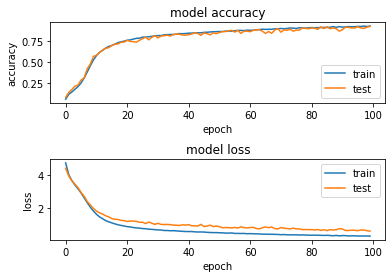

Final Test Accuracy: 0.9318935871124268


In [13]:
# Select the final model based on the max test accuracy across all models

best_model_index = model_accuracy.index(max(model_accuracy))

best_model = models[best_model_index]
best_model_history = model_history[best_model_index]
best_model_train_acc = model_train_acc[best_model_index]
best_model_train_loss = model_train_loss[best_model_index]
best_model_val_acc = model_val_acc[best_model_index]
best_model_val_loss = model_val_loss[best_model_index]

# summarize history for accuracy  
plt.subplot(211)  
plt.plot(best_model_history.history['accuracy'])  
plt.plot(best_model_history.history['val_accuracy'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='lower right')  

# summarize history for loss
plt.subplot(212)  
plt.plot(best_model_history.history['loss'])  
plt.plot(best_model_history.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='upper right')  
plt.subplots_adjust(hspace=0.7)

plt.show() 

print("Final Test Accuracy:", model_accuracy[best_model_index])

In [14]:
#Select only the optimal number of input features for X_test
X_test = X_test[:,:(best_model_index+1)]

# Evaluate the best model on the test data
y_pred = best_model.predict(X_test)

# np.argmax() is used to convert the one-hot encoded predictions and test labels to class labels.
y_pred_label = np.argmax(y_pred, axis = 1)

# Print the classification report
print("Classification report:\n", classification_report(y_test_enc, y_pred_label))

424/424 [==============================] - 1s 1ms/step
Classification report:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99       591
           1       1.00      1.00      1.00       430
           2       1.00      1.00      1.00       419
           3       1.00      1.00      1.00       384
           4       1.00      1.00      1.00       339
           5       0.99      1.00      0.99       342
           6       1.00      1.00      1.00       310
           7       1.00      1.00      1.00       325
           8       0.99      1.00      0.99       294
           9       0.92      1.00      0.96       269
          10       1.00      1.00      1.00       296
          11       1.00      1.00      1.00       258
          12       0.97      0.72      0.83       247
          13       0.98      1.00      0.99       237
          14       0.98      1.00      0.99       239
          15       1.00      1.00      1.00       235
  

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

In [15]:
# extract class labels from test data
class_test = y_test_enc

# Invert OsID_labels dictionary
inv_OsID_labels = {v: k for k, v in OsID_labels.items()}

# map OsID values to the class labels
OsID_test = [inv_OsID_labels.get(value, 'Unknown') for value in class_test]

# create dataframe with OsID, true class, predicted class, and true/false columns
results = pd.DataFrame({
    'OsID': OsID_test,
    'True Class': y_test_enc,
    'Predicted Class': y_pred_label,
    'True/False': class_test == y_pred_label
})

# display dataframe
print(results.head())

# save results_df to a CSV file
results.to_csv('MLP_gene classification.csv', index=False)

           OsID  True Class  Predicted Class  True/False
0  Os02g0655200         329              329        True
1  Os04g0659100         161              161        True
2  Os01g0686800          17               17        True
3  Os04g0107900          34               34        True
4  Os04g0517100           7                7        True


In [16]:
display(models_df)

,No of input features,Model accuracy
0,1,0.045
1,2,0.079
2,3,0.096
3,4,0.515
4,5,0.738
5,6,0.876
6,7,0.896
7,8,0.886
8,9,0.894
9,10,0.845
